## Answering Bussiness Questions using SQL

In [1]:
#import library
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
#create function
def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)

def run_command(c):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)
        
def show_table():
    q1 = '''SELECT
                name,
                type
            FROM sqlite_master
            WHERE type IN ("table", "view");'''
    return run_query(q1)


In [3]:
#check the data
q1 = '''SELECT
            name,
            type
        FROM sqlite_master
        WHERE type IN ("table", "view");'''

show_table = run_query(q1)
show_table

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


## Selecting Albums to Purchase

In [4]:
q2 = '''WITH
            country AS
                (
                    SELECT
                        il.track_id,
                        c.country
                    FROM invoice_line il
                    INNER JOIN invoice i ON i.invoice_id = il.invoice_id
                    INNER JOIN customer c ON c.customer_id = i.customer_id
                ),
            genre_track AS
                (
                    SELECT
                        t.track_id,
                        t.name name_track,
                        g.name name_genre
                    FROM track t
                    INNER join genre g ON g.genre_id = t.genre_id
                )
        
        SELECT
            gt.name_genre,
            COUNT(gt.name_track) n_track
        FROM genre_track gt
        INNER JOIN country c ON c.track_id = gt.track_id
        WHERE country = "USA"
        GROUP BY 1
        ORDER BY 2 DESC'''

data_sell_genre_usa = run_query(q2).head(10)
data_sell_genre_usa['percent_track_sold'] = round((data_sell_genre_usa['n_track'] / sum(data_sell_genre_usa['n_track']) * 100),2)
data_sell_genre_usa.set_index('name_genre', inplace=True, drop=True)

In [5]:
data_sell_genre_usa 

,n_track,percent_track_sold
name_genre,,
Rock,561,55.16
Alternative & Punk,130,12.78
Metal,124,12.19
R&B/Soul,53,5.21
Blues,36,3.54
Alternative,35,3.44
Latin,22,2.16
Pop,22,2.16
Hip Hop/Rap,20,1.97


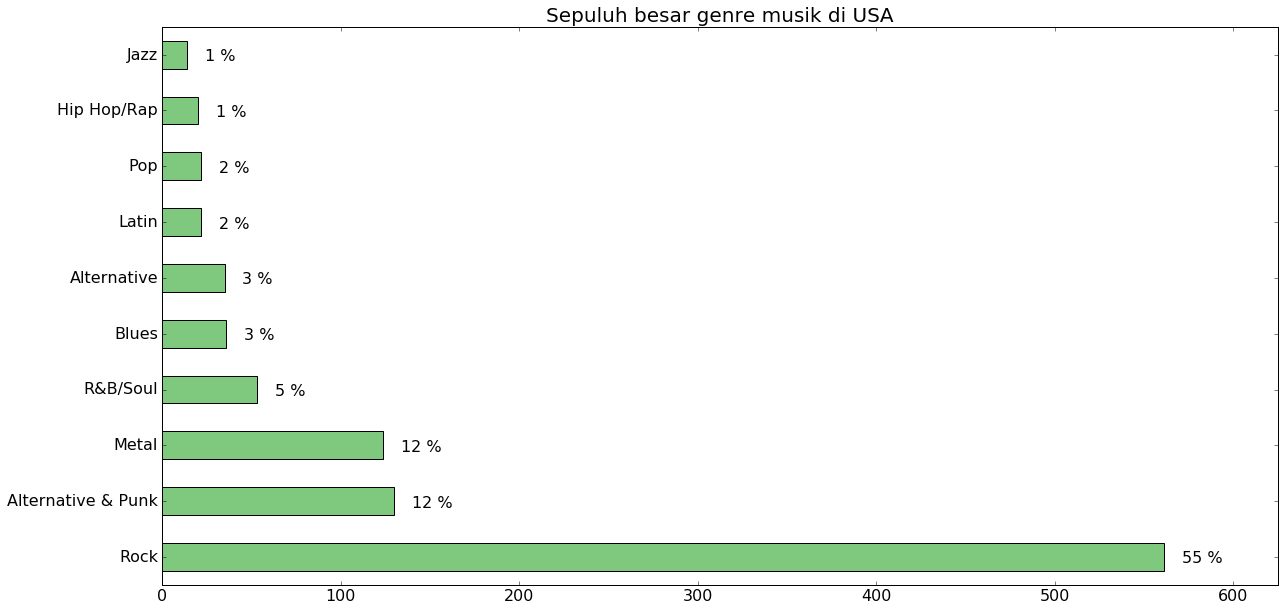

In [6]:
data_sell_genre_usa['n_track'].plot.barh(xlim=(0,625), fontsize=16,
                             colormap=plt.cm.Accent, figsize=(20,10))
plt.ylabel('')
plt.title('Sepuluh besar genre musik di USA', fontsize = 20)

for i,label in enumerate(list(data_sell_genre_usa.index)):
    score = data_sell_genre_usa.loc[label, 'n_track']
    percent = (data_sell_genre_usa.loc[label, 'percent_track_sold']).astype(int).astype(str) + ' %'
    plt.annotate(str(percent), (score + 10, i-0.11), fontsize=16)
    

plt.show()

dari data yang telah diolah, terdapat beberapa informasi yang dapat diambil
1. mayoritas pembeli dari USA menyukai genre music rock, hal ini bisa dilihat dari data dimana 50 persen lebih berasal dari genre rock, kemudian disusul alternative & punk 12.37 persen

2. dari 4 artist yang baru, 3 artist yang akan direkomendasikan adalah yang berasal dari genre punk , pop , dan blues, karena data penjualan ketiga tersebut lebih tinggi dati hip-hop

## Analyzing Employee Sales Performance

In [7]:
q3 = '''WITH
            employee_sales AS
                (
                    SELECT
                       c.customer_id,
                       e.title,
                       e.hire_date,
                       e.first_name || " " || e.last_name employee_name
                    FROM customer c
                    INNER JOIN employee e ON e.employee_id = c.support_rep_id
                ),
            total_sales AS
                (
                    SELECT
                        customer_id,
                        SUM(total) total_sale
                    FROM invoice
                    GROUP BY 1
                )
        SELECT
            es.employee_name,
            es.hire_date,
            SUM(t.total_sale) total_sales
        FROM employee_sales es
        INNER JOIN total_sales t ON t.customer_id = es.customer_id
        WHERE es.title = "Sales Support Agent"
        GROUP BY 1
        ORDER BY 2 DESC ;
        '''

employee_sales_peformance = run_query(q3)
employee_sales_peformance.set_index('employee_name', inplace=True, drop=True)
employee_sales_peformance.sort_values('total_sales', inplace=True)

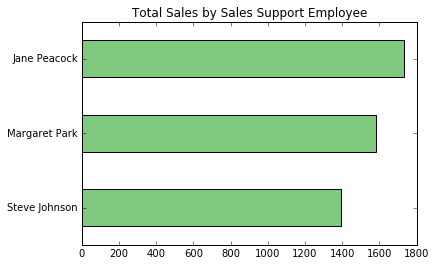

In [8]:
employee_sales_peformance.plot.barh(legend=False, title ='Total Sales by Sales Support Employee', colormap = plt.cm.Accent)
plt.ylabel('')
plt.show()

dari data, didapatkan bahwa jane peacock memliki jumlah sales paling tinggi, diikuti margaret and steve

## Analyzing Sales by Country

In [9]:
q4 = '''WITH
            country_or_other AS
                (
                    SELECT
                        CASE
                            WHEN
                                (SELECT COUNT(*)
                                FROM customer
                                WHERE country = c.country
                                ) = 1 THEN "other"
                            ELSE c.country
                        END AS country,
                        c.customer_id,
                        il.*
                        FROM invoice_line il
                        INNER JOIN invoice i ON i.invoice_id = il.invoice_id
                        INNER JOIN customer c ON c.customer_id = i.customer_id
                )
        
        SELECT
            country,
            customer,
            percent_customer,
            total_sales,
            average_order,
            customer_lifetime_value
        FROM
            (
                SELECT
                    country,
                    COUNT(distinct customer_id) customer,
                    CAST(COUNT(distinct customer_id) AS FLOAT) / (SELECT SUM(n_customer) FROM(SELECT country,
                                                                                        COUNT(distinct customer_id) n_customer
                                                                                        FROM country_or_other
                                                                                        GROUP BY country)) * 100 percent_customer,
                    SUM(unit_price) total_sales,
                    SUM(unit_price) / COUNT(distinct invoice_id) average_order,
                    SUM(unit_price) / COUNT(distinct customer_id) customer_lifetime_value,
                    CASE
                        WHEN country = 'other' THEN 1
                        ELSE 0
                    END AS sort
                FROM country_or_other
                GROUP BY country
                ORDER BY sort ASC, customer DESC
            )
        '''
sales_by_country = run_query(q4)
sales_by_country.set_index('country', inplace=True, drop=True)

In [10]:
sales_by_country

,customer,percent_customer,total_sales,average_order,customer_lifetime_value
country,,,,,
USA,13,22.033898,1040.49,7.942672,80.037692
Canada,8,13.559322,535.59,7.047237,66.948750
Brazil,5,8.474576,427.68,7.011148,85.536000
France,5,8.474576,389.07,7.781400,77.814000
Germany,4,6.779661,334.62,8.161463,83.655000
United Kingdom,3,5.084746,245.52,8.768571,81.840000
Czech Republic,2,3.389831,273.24,9.108000,136.620000
India,2,3.389831,183.15,8.721429,91.575000
Portugal,2,3.389831,185.13,6.383793,92.565000


### visualizing sales by country

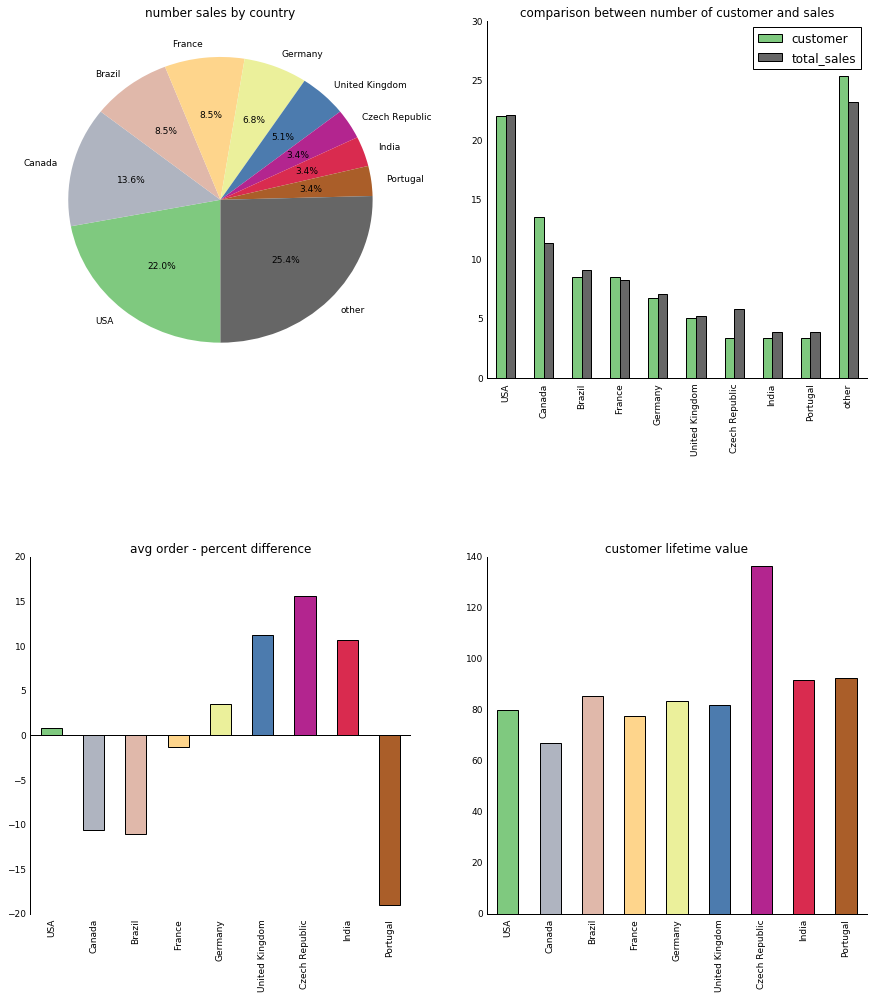

In [13]:
#visualizing sales by country dataset
import numpy as np

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,16))
ax1, ax2, ax3, ax4 = ax.flatten()
fig.subplots_adjust(hspace=0.5)
colors =[plt.cm.Accent(i) for i in np.linspace(0,1, sales_by_country.shape[0])]
fsize = 9

#first

n_sales_by_country = sales_by_country['customer'].copy().rename('')
n_sales_by_country.plot.pie(ax=ax1, 
                            startangle=-90, 
                            counterclock=False, 
                            title = 'number sales by country', 
                            fontsize = fsize,
                            colormap=plt.cm.Accent, 
                            autopct='%1.1f%%',
                           wedgeprops={'linewidth':0})



#second
customer_n_sales_col = ['customer','total_sales']
customer_n_sales = sales_by_country[customer_n_sales_col].copy()
customer_n_sales.index.name = ''

for c in customer_n_sales_col:
    customer_n_sales[c] = customer_n_sales[c] / customer_n_sales[c].sum() * 100
customer_n_sales.plot.bar(ax=ax2, 
                           title = 'comparison between number of customer and sales',
                           fontsize = fsize,
                          colormap = plt.cm.Accent)

ax2.tick_params(bottom='off', top='off', left='off',right='off' )
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

#because we try to find which country have potential, i will remove other because it's just represent country with 1 sales

#third
avg_order = sales_by_country['average_order'].copy()
avg_order.index.name=''
avg_order.drop('other', inplace = True)
percent_difference = avg_order * 100 / avg_order.mean() - 100

percent_difference.plot.bar(ax=ax3,
                   title = 'avg order - percent difference',
                   fontsize = fsize,
                  color=colors)

ax3.tick_params(bottom='off', top='off', left='off',right='off' )
ax3.axhline(0, color='k')
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.spines["bottom"].set_visible(False)

#fourth

cus_livetime_value = sales_by_country['customer_lifetime_value'].copy()
cus_livetime_value.index.name = ''
cus_livetime_value.drop('other', inplace=True)
cus_livetime_value.plot.bar(ax=ax4,
                   title = 'customer lifetime value',
                   fontsize = fsize,
                  color=colors)

ax4.tick_params(bottom='off', top='off', left='off',right='off' )
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)

plt.show()

dari data, saya akan merekomendasikan UK, czech republik dan india sebagai negara dengan potensi perkembangan tertinggi, hal ini dapat terlihat ketiga negara tersebut memiliki persen difference positif paling tinggi untuk rata-rata sales (gambar kiri bawah) , dan memiliki rata-rata order tertinggi(gambar kanan bawah)

data other tidak menjadi pertimbangan karena hanya mewakili satu negara yang hanya memiliki 1 sales

namun data diatas belum bisa dijadikan pengambilan keputusan karena hanya memiliki jumlah data yang sedikit, agar bisa dijadikan pengambilan keputusan, data perlu ditambah atau melakukan survei dan promosi di 3 negara dengan potensi paling tinggi

### Album vs Individual Track

In [12]:
q5 = '''WITH 
            invoice_first_track AS
               (
                   SELECT
                       il.invoice_id,
                       MIN(il.track_id) first_track
                    FROM invoice_line il
                    GROUP BY 1
               )
        
        SELECT
            album_purchase,
            COUNT(invoice_id) number_of_invoice,
            CAST(COUNT(invoice_id) AS FLOAT) / (SELECT COUNT(*) 
                                                FROM invoice) * 100 percent
        FROM
            (
                SELECT
                    ifs.*,
                    CASE
                        WHEN
                            (
                                SELECT t.track_id FROM track t
                                WHERE t.album_id = (SELECT t2.album_id FROM track t2
                                                    WHERE t2.track_id = ifs.first_track)
                                
                                EXCEPT
                                
                                SELECT il2.track_id FROM invoice_line il2
                                WHERE il2.invoice_id = ifs.invoice_id
                            ) IS NULL
                        AND
                            (
                                SELECT il2.track_id FROM invoice_line il2
                                WHERE il2.invoice_id = ifs.invoice_id
                                
                                EXCEPT
                                
                                SELECT t.track_id FROM track t
                                WHERE t.album_id = (SELECT t2.album_id FROM track t2
                                                    WHERE t2.track_id = ifs.first_track)
                            ) IS NULL
                        THEN "yes"
                        ELSE "no"
                    END AS "album_purchase"
                FROM invoice_first_track ifs
            )
        GROUP BY album_purchase
        '''

run_query(q5)

,album_purchase,number_of_invoice,percent
0,no,500,81.433225
1,yes,114,18.566775


dari data terlihat jika cuma 18 persen customer yang membeli track di semua album, sehingga lebih direkomendisikan untuk mengambil beberapa track dalam album